In [1]:
import torch 
from torch import optim
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence

import matplotlib.pyplot as plt
from tqdm import tqdm

from model.model import SentenceEncoder, SentenceDecoder, ImageEncoder, cnnTransforms, Gesd
from dataset import VisDialDataset
from utils.token import Lang
from utils.beamSearch import BeamSearch

from VQAFeature.model import VQADualModel
from VQAFeature.utils import setDualData
from VQA.utils import setData, collate_fn

jsonFile = "/home/ball/dataset/mscoco/visdialog/visdial_1.0_val.json"
cocoDir = "/home/ball/dataset/mscoco/"
sentFeature = "visdial_train.h5"
langFile = "dataset/lang.pkl"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# DEVICE = torch.device("cpu")
print(DEVICE)

cuda


In [5]:
lang = Lang.load(langFile)
dataset = VisDialDataset(dialFile = jsonFile,
                         cocoDir = cocoDir, 
                         sentTransform = torch.LongTensor,
                         imgTransform = cnnTransforms,
                         convertSentence = lang.sentenceToVector
                        )

Load lang model: dataset/lang.pkl. Word size: 43974


Preparing image paths with image_ids: 133351it [00:00, 380986.09it/s]


In [3]:
loader = torch.utils.data.DataLoader(dataset, 
                                     batch_size=2, 
                                     shuffle=True, 
                                     num_workers=0, 
                                     collate_fn=VisDialDataset.collate_fn)
it = iter(loader)

In [36]:
data = it.next()
images_t, questions_t, answers_t, label_t = setDualData(data, lang, DEVICE)

In [39]:
image_setting = {
    "output_size": 1024,
    "pretrained": False
}
sentence_setting = {
    "word_size": len(lang),
    "output_size": 512
}

model = VQADualModel(image_setting, sentence_setting).to(DEVICE)

In [10]:
model = torch.load("VQAFeature/models/fulldual2/VQAmodel.8.pth").to(DEVICE).eval()

In [13]:
from tqdm import tqdm
mrrs = []
scores = []
for i in tqdm(range(100)):
    data = VisDialDataset.collate_fn(dataset[i*10:i*10+1])
    images_t, questions_t, answers_t, label_t = setDualData(data, lang, DEVICE, negsimple=0)
    iq_outputs = model.imageQuestion(images_t, questions_t)
    a_outputs = model.answer(answers_t)
    mrr, score = eval(iq_outputs, a_outputs)
    mrrs.append(mrr)
    scores.append(score)
torch.stack(mrrs).mean()

100%|██████████| 100/100 [00:03<00:00, 28.63it/s]


tensor(0.4407)

In [7]:
def eval(inputs, targets):
    #inputs: batch * feature
    #targets: batch * feature(each answer's feature)
    criterion = Gesd(dim=2)
    batch = inputs.size(0)
    inputs = inputs.unsqueeze(1).repeat(1, batch, 1)
    targets = targets.unsqueeze(0).repeat(batch, 1, 1)
    
    score = criterion(inputs, targets)
    vals, orders = score.sort(descending=True, dim=1)
    table = torch.arange(batch).unsqueeze(1).repeat(1, batch)
    idx_orders = (table == orders.cpu()).nonzero()[:, 1].float()
    mrr = (1/(idx_orders+1)).mean()
#     mrr = idx_orders.mean()
    return mrr.detach(), vals[:,0].detach()

In [6]:
decodeModel = torch.load("SentenceDecode/models/20dualans/DecodeModel.49.pth")

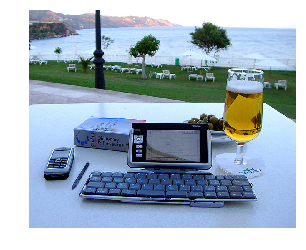

Question:what color is the tablet
Answer	:the walls are a little tan
GT	:black and silver

Question:is it on a desk
Answer	:i think it's the bottom part of the toilet
GT	:no

Question:is it on a table
Answer	:it is pretty small
GT	:yes

Question:what color is the table
Answer	:1 of the photo is black and white, the other is light brown
GT	:white

Question:are there other objects on the table
Answer	:i can see the street
GT	:yes

Question:what is 1 other object
Answer	:a red semi
GT	:cell

Question:is there a person in the picture
Answer	:i can tell, i see the driver only
GT	:no

Question:is the tablet on
Answer	:it does not look like a tree
GT	:yes

Question:what color is the screen
Answer	:the 1 is dark the other is brown
GT	:white

Question:is there any text on the screen
Answer	:it looks like the trees are empty
GT	:yes



In [10]:
data = dataset[15]
bs = BeamSearch(model.imageQuestion, decodeModel, lang, DEVICE, 1)
answers_p = []
for question, answer in zip(data["questions"], data["answers"]):
    ans, probs = bs.predit(input_imgs=cnnTransforms(data["image"]).unsqueeze(0).to(DEVICE), 
                           input_questions=[question.to(DEVICE)])
    answers_p.append({
        "question": lang.vectorToSentence(question.numpy()),
        "answer": ans,
        "answer_GT": lang.vectorToSentence(answer.numpy())
    })
plt.axis('off')
plt.imshow(data["image"])
plt.show()
for r in answers_p:
    print("Question:{}\nAnswer\t:{}\nGT\t:{}\n".format(r["question"], r["answer"], r["answer_GT"]))

In [5]:
data = dataset[10]
bs = BeamSearch(model.answer, decodeModel, lang, DEVICE, 2)

In [13]:
sources = []
issame = []
allsent = dataset.getAllSentences()
for i in tqdm(range(100)):
    data = allsent[i:i+1]
    gt = lang.vectorToSentence(data[0])
    pred, probs = bs.predit(input_answer=torch.LongTensor(data).to(DEVICE))
    sources.append([gt, pred])
    issame.append(gt == pred)

100%|██████████| 100/100 [00:01<00:00, 68.33it/s]


In [14]:
issame

[False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False]

(['is someone took his arms outstretched, police officers no hats'],
 [0.03802299499511719])